<img src="../LogoUTN.jpg" align="right" width="150" /> 

### Procesamiento Digital de Señales - 2024

# Trabajo Práctico Nº8: Ancho de banda del Electrocardiograma
### Juan Manuel Ronchetti

## Introduccion

Se provee el archivo ECG_TP4.mat, donde se encuentra un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación:
* ecg_lead: Registro de ECG muestreado a fs=1 KHz durante una prueba de esfuerzo
* qrs_pattern1: Complejo de ondas QRS normal
* heartbeat_pattern1: Latido normal
* heartbeat_pattern2: Latido de origen ventricular
* qrs_detections: vector con las localizaciones (en # de muestras) donde ocurren los latidos

Se pide:
* Graficar los latidos normales y ventriculares, normalizados y alineados
* Realizar gráficos donde se comparen La densidad espectral (PSD) de los primeros 10 segundos de ECG limpio, la PSD de todas las realizaciones de latidos en una ventana que va desde (R_i - 250 ms - R_i + 350 ms) para los i-ésimos latidos, y la PSD de todo el registro.
* Analizar las diferencias entre cada grafico
* Establecer una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a suavidad de los trazos y nivel isoeléctrico nulo

## Preparacion de la simulacion

In [1]:
# -------------------------------------------------------------------------------
#                                   Imports
# -------------------------------------------------------------------------------

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import welch
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------------------
#                                Lectura de datos
# -------------------------------------------------------------------------------

# Lectura de ECG 
data = scipy.io.loadmat('ECG_TP4.mat')

# Extraer las variables del archivo
ecg_lead = data['ecg_lead'].flatten()
qrs_detections = data['qrs_detections'].flatten()
heartbeat_pattern1 = data['heartbeat_pattern1'].flatten()
heartbeat_pattern2 = data['heartbeat_pattern2'].flatten()

# Parametros
fs = 1000 
duration = 10

# -------------------------------------------------------------------------------
#                          Funcion para obtener ancho de banda
# -------------------------------------------------------------------------------

def estimate_bandwidth(frequencies, psd):
    total_energy = np.sum(psd)
    energy_threshold = 0.99 * total_energy
    
    cumulative_energy = np.cumsum(psd)
    
    lower_limit_index = np.where(cumulative_energy >= (total_energy - energy_threshold))[0][0]
    upper_limit_index = np.where(cumulative_energy >= energy_threshold)[0][0]

    bandwidth = frequencies[upper_limit_index] - frequencies[lower_limit_index]
    central_frequency = (frequencies[lower_limit_index] + frequencies[upper_limit_index]) / 2
    
    return bandwidth, central_frequency, frequencies[lower_limit_index], frequencies[upper_limit_index]

## Estimacion de pulsaciones por minuto

In [2]:
# Calcular las distancias entre cada valor y el siguiente
distances = np.diff(qrs_detections) / fs

mean_distance = np.mean(distances)
er = np.std(distances)/mean_distance * 100

heart_rate = 1/mean_distance
heart_rate_bpm = 60 * heart_rate

# Mostrar resultados
print(f"Frecuencia cardíaca estimada: {heart_rate_bpm:.2f} latidos por minuto")
print(f"Desvio/media: {er:.2f} %")

Frecuencia cardíaca estimada: 101.17 latidos por minuto
Desvio/media: 28.27 %


## Graficos de Latidos

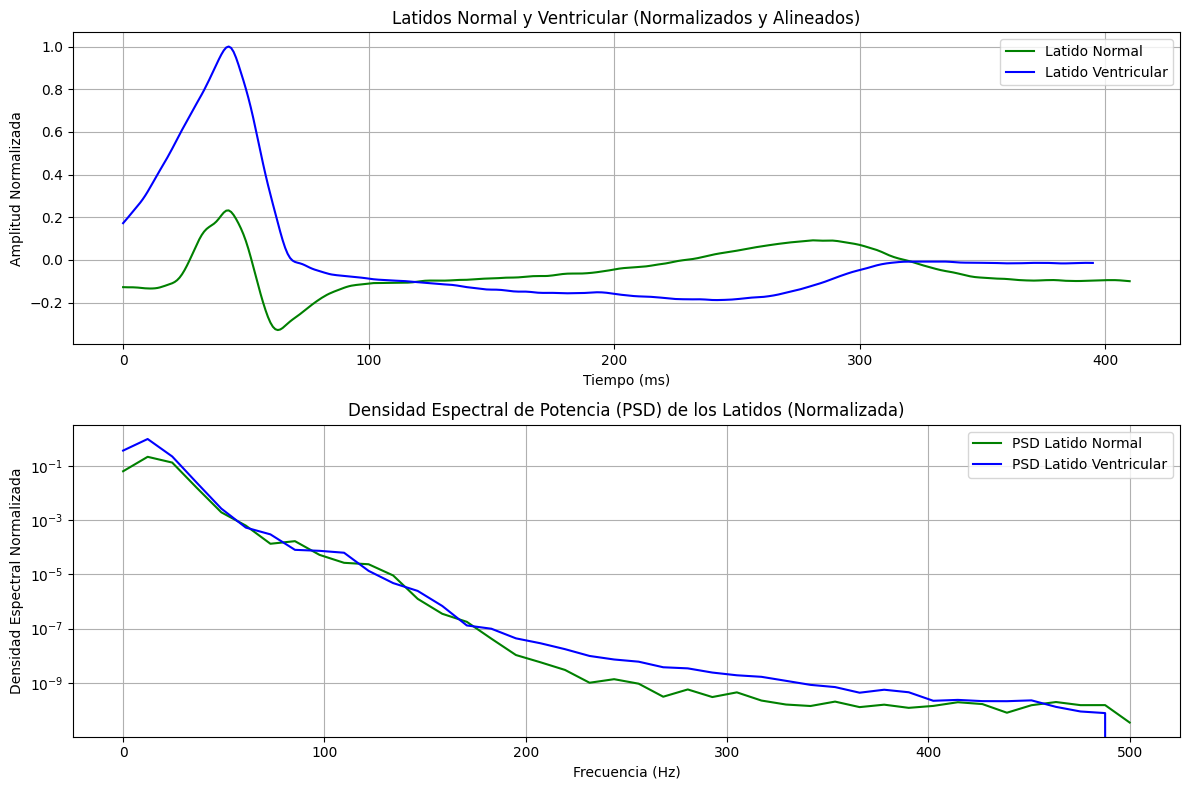

In [3]:
# Determinar el pico maximo entre ambos latidos para normalizar
max_peak = max(np.max(np.abs(heartbeat_pattern1)), np.max(np.abs(heartbeat_pattern2)))

# Normalizar los latidos usando el pico maximo y alinear
heartbeat_pattern1_normalized = heartbeat_pattern1 / max_peak
heartbeat_pattern2_normalized = heartbeat_pattern2 / max_peak
r_peak_index_normal = np.argmax(heartbeat_pattern1_normalized)
r_peak_index_ventricular = np.argmax(heartbeat_pattern2_normalized)
shift_amount = r_peak_index_normal - r_peak_index_ventricular

# Desplazar el latido ventricular para alinear con el latido normal
if shift_amount > 0:
    heartbeat_pattern2_aligned = np.pad(heartbeat_pattern2_normalized, (shift_amount, 0), 'constant')[:-shift_amount]
else:
    heartbeat_pattern2_aligned = heartbeat_pattern2_normalized[-shift_amount:]

# Graficar latidos normalizados y alineados
plt.figure(figsize=(12, 8))

# Subplot 1: Latido normal y ventricular alineados
plt.subplot(2, 1, 1)
time_axis_normal = np.arange(len(heartbeat_pattern1_normalized))   
time_axis_ventricular = np.arange(len(heartbeat_pattern2_aligned)) 

plt.plot(time_axis_normal, heartbeat_pattern1_normalized, label='Latido Normal', color='green')
plt.plot(time_axis_ventricular, heartbeat_pattern2_aligned, label='Latido Ventricular', color='blue')
plt.title('Latidos Normal y Ventricular (Normalizados y Alineados)')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud Normalizada')
plt.legend()
plt.grid()

# Subplot 2: Espectros normalizados de los latidos
plt.subplot(2, 1, 2)

N = len(heartbeat_pattern1)
nperseg = N // 5 
noverlap = nperseg // 2

# Welch para PSD
frequencies_heartbeat1, psd_heartbeat1 = welch(heartbeat_pattern1, fs=fs, nperseg=nperseg, noverlap=noverlap)
frequencies_heartbeat2, psd_heartbeat2 = welch(heartbeat_pattern2, fs=fs, nperseg=nperseg, noverlap=noverlap)

# Normalizo PSD entre 0 y 1
psd_heartbeat_min = min(np.min(np.abs(psd_heartbeat1)), np.min(np.abs(psd_heartbeat2)))
psd_heartbeat_max = max(np.max(np.abs(psd_heartbeat1)), np.max(np.abs(psd_heartbeat2)))

psd_heartbeat1_normalized = (psd_heartbeat1 - psd_heartbeat_min) / (psd_heartbeat_max - psd_heartbeat_min)
psd_heartbeat2_normalized = (psd_heartbeat2 - psd_heartbeat_min) / (psd_heartbeat_max - psd_heartbeat_min)

plt.semilogy(frequencies_heartbeat1, psd_heartbeat1_normalized, label='PSD Latido Normal', color='green')
plt.semilogy(frequencies_heartbeat2, psd_heartbeat2_normalized, label='PSD Latido Ventricular', color='blue')
plt.title('Densidad Espectral de Potencia (PSD) de los Latidos (Normalizada)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad Espectral Normalizada')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Graficos de ECG

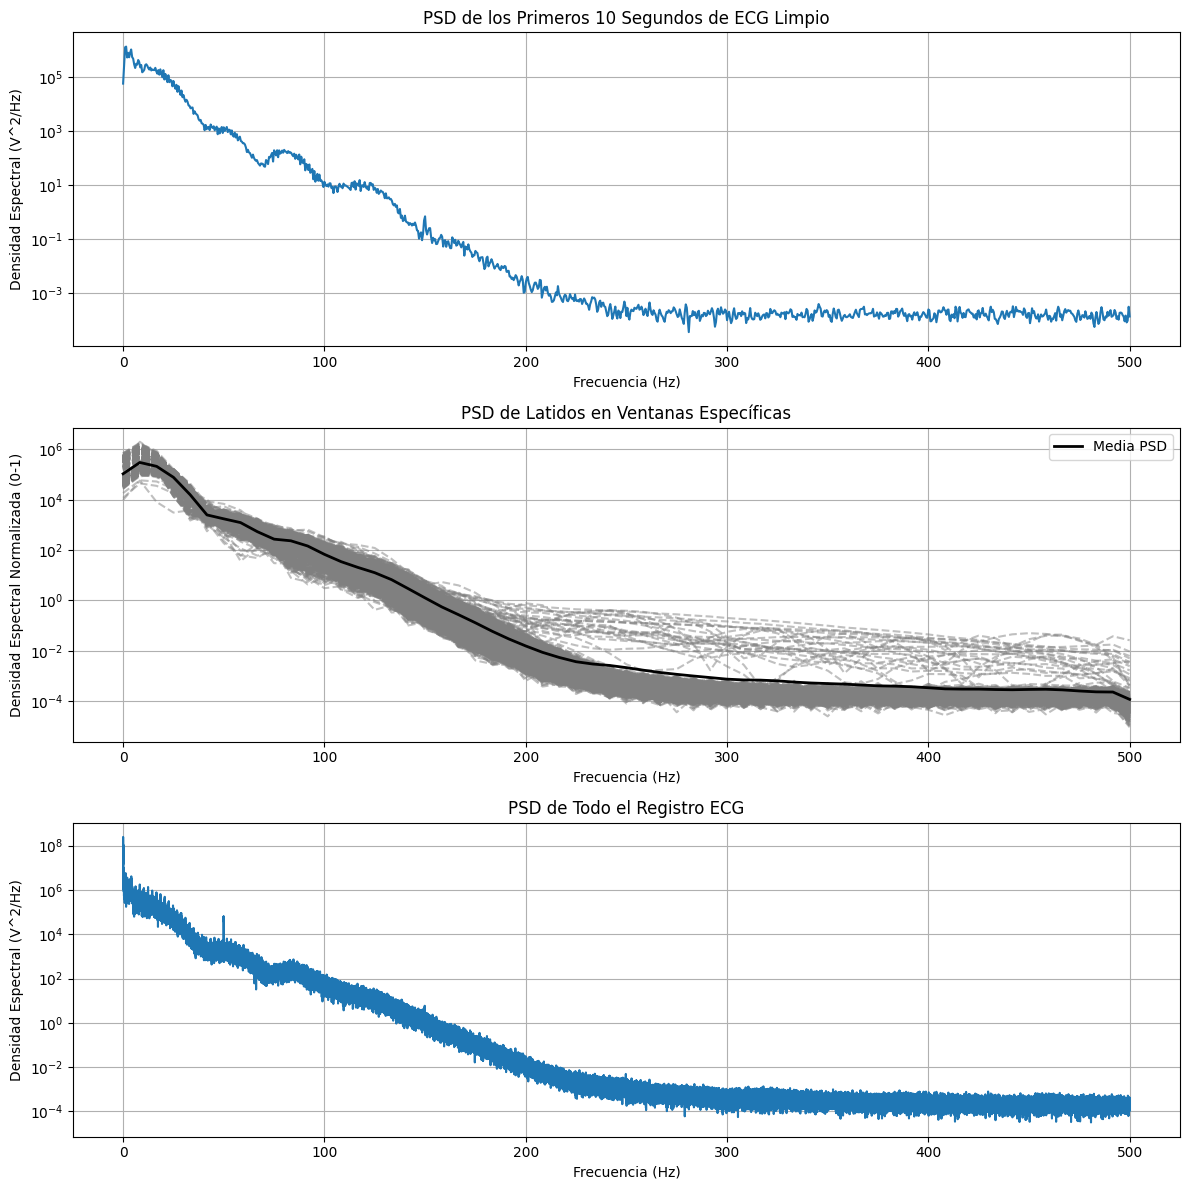

In [6]:
# Para almacenar y mostrar al final
resultados = []

def append_result(signal, bw, fc, f1, f2):
    resultados.append({
        'Señal': signal,
        'Ancho de Banda (Hz)': bw,
        'Frecuencia Central (Hz)': fc,
        'Límite Inferior (Hz)': f1,
        'Límite Superior (Hz)': f2
    })

fig, axs = plt.subplots(3, 1, figsize=(12, 12))

# ------------------ PSD del ECG limpio (primeros 10 segundos) ------------------
ecg_clean_segment = ecg_lead[:duration * fs]
N = len(ecg_clean_segment)
nperseg = N // 5 
noverlap = nperseg // 2

frequencies_ecg_clean, psd_ecg_clean = welch(ecg_clean_segment, fs=fs, nperseg=nperseg, noverlap=noverlap)

# Calculo ancho de banda y almaceno para la tabla
bw_1, fc_1, f1_1, f2_1 = estimate_bandwidth(frequencies_ecg_clean, psd_ecg_clean)
append_result('ECG Limpio', bw_1, fc_1, f1_1, f2_1 )

axs[0].semilogy(frequencies_ecg_clean, psd_ecg_clean)
axs[0].set_title('PSD de los Primeros 10 Segundos de ECG Limpio')
axs[0].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('Densidad Espectral (V^2/Hz)')
axs[0].grid()

# ------------------ PSDs de los latidos en ventanas ------------------
psd_list = []
frequencies_list = []

for i in range(len(qrs_detections)):
    # Ventana alrededor del latido
    start_idx = int(qrs_detections[i] - (250 / 1000) * fs)
    end_idx = int(qrs_detections[i] + (350 / 1000) * fs)
    
    if start_idx >= 0 and end_idx < len(ecg_lead):
        heartbeat_segment = ecg_lead[start_idx:end_idx]
        
        N = len(heartbeat_segment)
        nperseg = N // 5 
        noverlap = nperseg // 2
        
        frequencies_beat, psd_beat = welch(heartbeat_segment, fs=fs, nperseg=nperseg, noverlap=noverlap)
        
        psd_list.append(psd_beat)
        frequencies_list.append(frequencies_beat)

        # Graficar la PSD individual como linea punteada
        axs[1].semilogy(frequencies_beat, psd_beat, linestyle='--', color='gray', alpha=0.5)

mean_psd_normalized = np.mean(psd_list, axis=0)

# Calculo ancho de banda y almaceno para la tabla
bw_2, fc_2, f1_2, f2_2 = estimate_bandwidth(frequencies_list[0], mean_psd_normalized)
append_result('Media de las realizaciones en ventana', bw_2, fc_2, f1_2, f2_2 )

axs[1].semilogy(frequencies_list[0], mean_psd_normalized, label='Media PSD', color='black', linewidth=2)
axs[1].set_title('PSD de Latidos en Ventanas Específicas')
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel('Densidad Espectral Normalizada (0-1)')
axs[1].legend()
axs[1].grid()

# ------------------ PSD de todo el registro ------------------
N = len(ecg_lead)
nperseg = N // 5 
noverlap = nperseg // 2

frequencies_full_ecg, psd_full_ecg = welch(ecg_lead, fs=fs, nperseg=nperseg, noverlap=noverlap)

# Calculo ancho de banda y almaceno para la tabla
bw_3, fc_3, f1_3, f2_3 = estimate_bandwidth(frequencies_full_ecg, psd_full_ecg)
append_result('ECG Completo', bw_3, fc_3, f1_3, f2_3)

axs[2].semilogy(frequencies_full_ecg, psd_full_ecg)
axs[2].set_title('PSD de Todo el Registro ECG')
axs[2].set_xlabel('Frecuencia (Hz)')
axs[2].set_ylabel('Densidad Espectral (V^2/Hz)')
axs[2].grid()

plt.tight_layout()
plt.show()

## Tabla de resultados

In [7]:
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by=['Señal'], inplace=True)
styled_table = df_resultados.style.hide(axis="index").format(precision=3)
styled_table

Señal,Ancho de Banda (Hz),Frecuencia Central (Hz),Límite Inferior (Hz),Límite Superior (Hz)
ECG Completo,26.733,13.371,0.004,26.738
ECG Limpio,30.500,15.750,0.500,31.000
Media de las realizaciones en ventana,33.333,16.667,0.000,33.333


## Analisis de Resultados
Se observa que se obtuvo la PSD del ECG limpio, el completo y del promedio de las ventanas. De ellos se puede extraer la siguiente informacion:
* La PSD promediada de las ventanas es la mas suave de todas, debido a que entre interaciones se va limpiando del ruido.
* La PSD de los primeros 10 segundos es afectada por el ruido, pero aun asi se puede apreciar correctamente.
* En la PSD de todo el registro se pueden observar picos de interferencia en las cercanias a 0 Hz y en 50 Hz, asi como bastante ruido en el resto del espectro.

## Propuesta de Plantilla de Filtro
Observando las caracteristicas del ancho de banda del ECG obtenidas, se define la siguiente plantilla para filtrar la señal y que se asemeje a los latidos promedio en cuanto a suavidad de los trazos y nivel isoeléctrico nulo:
* fs0 = 1 Hz   (Fin de la banda de detenida)
* fc0 = 3 Hz   (Comienzo de la banda de paso)
* fc1 = 25 Hz   (Fin de la banda de paso)
* fs1 = 35 Hz   (Comienzo de la banda de detenida)

## Conclusiones
Dado el archivo de registro electrocardiografico, se pudo obtener y graficar los latidos normales y ventriculares, con los cuales se estimaron las pulsaciones por minuto promedio de la prueba de esfuerzo.

A su vez, se obtuvo la densidad espectral de potencia del ECG, en tres alternativas: completa, los primeros 10 segundos, y promediado luego de un ventaneo. De esta manera se pudo analizar sus caracteristicas y definir la plantilla para implementar un filtro que suavice los trazos.